In [71]:
# RESTART KERNEL AND RELOAD MODULES TO PICK UP LATEST CHANGES
# Run this cell first if you're experiencing "unexpected keyword argument" errors

import sys
import importlib

# Clear any cached modules
modules_to_clear = [key for key in sys.modules.keys() if key.startswith('proteomics_toolkit')]
for module in modules_to_clear:
    del sys.modules[module]

print("✓ Cleared cached modules")
print("✓ Now run the next cell to import fresh modules with all updates")

In [72]:
# =============================================================================
# PROTEOMICS ANALYSIS CONFIGURATION
# =============================================================================

# =============================================================================
# 1. INPUT FILES AND PATHS
# =============================================================================
toolkit_path = "."
metadata_file = "example_data/2025-6-CSF-Total-Pilot-MetaData.csv"
protein_file = "example_data/2025-6-CSF-Total-Pilot-ProteinQuant.csv" 
peptide_file = "example_data/2025-6-CSF-Total-Pilot-PeptideQuant.csv"

# Sample processing options
remove_common_prefix = True  # Clean up sample names

# =============================================================================
# 2. DATA FILTERING PARAMETERS  
# =============================================================================
min_detection_rate = 0.5  # Minimum 50% detection across samples

# =============================================================================
# 3. NORMALIZATION STRATEGY
# =============================================================================
# Select ONE normalization method:
#   "VSN" - Variance Stabilizing Normalization (RECOMMENDED - handles heteroscedastic data)
#   "Median" - Simple median normalization (preserves original scale)  
#   "Quantile" - Makes sample distributions identical
#   "MAD" - Median Absolute Deviation (robust to outliers)
#   "Z-score" - Standardizes to mean=0, std=1
#   "RLR" - Robust Linear Regression (good for batch effects)
#   "LOESS" - Locally weighted regression (intensity-dependent bias)
#   "None" - No normalization applied

normalization_method = "Median"

# VSN-specific settings (only used if normalization_method = "VSN")
optimize_vsn = False  # Use parameter optimization for VSN (RECOMMENDED: True for final analysis, False for speed)

# =============================================================================
# 4. NEGATIVE VALUE HANDLING STRATEGY
# =============================================================================
# VSN normalization produces negative values - this is NORMAL and EXPECTED
# For CSF biomarker studies, negative values should typically be KEPT
handle_negatives = True  # Set to False to keep VSN negative values (RECOMMENDED)

# If handle_negatives = True, choose method (ignored when handle_negatives = False):
negative_handling_method = "min_positive"  # Options: "keep", "min_positive", "nan", "zero"
min_positive_replacement = None  # If None, uses 1/10th of smallest positive value

# =============================================================================
# 5. LOG TRANSFORMATION FOR STATISTICAL ANALYSIS (NEW!)
# =============================================================================
# CRITICAL: Some normalization methods preserve linear scale, but statistical tests
# assume log-transformed data for proper fold change interpretation

# Log transformation control:
#   "auto" - Automatically detect if log transformation is needed based on normalization method
#   True - Always apply log2 transformation before statistical analysis  
#   False - Never apply log transformation (use only if data is already log-transformed)
log_transform_before_stats = "auto"  # RECOMMENDED: "auto"

# Log transformation settings (only used if log transformation is applied):
log_base = "log2"  # Options: "log2", "log10", "ln" - log2 recommended for proteomics
log_pseudocount = None  # Auto-calculated small value to handle zeros (or set manually, e.g., 1e-6)

# =============================================================================
# 6. STATISTICAL ANALYSIS STRATEGY
# =============================================================================
# Select ONE statistical method:
#   "mixed_effects" - Mixed-effects model with interactions (RECOMMENDED for complex designs)
#   "paired_t" - Paired t-test (simple before/after comparison)
#   "paired_welch" - Paired Welch's t-test (more robust)
#   "welch_t" - Welch's t-test (unpaired groups)
#   "student_t" - Student's t-test (unpaired, equal variances)
#   "mann_whitney" - Mann-Whitney U test (non-parametric, unpaired)
#   "wilcoxon" - Wilcoxon signed-rank test (non-parametric, paired)

statistical_test_method = "mixed_effects"

# Analysis type (for simple tests only - ignored by mixed_effects)
analysis_type = "paired"  # "paired" or "unpaired"

# =============================================================================
# 7. EXPERIMENTAL DESIGN CONFIGURATION
# =============================================================================
# Basic experimental design
subject_column = "Subject"  # Column in metadata for subject identification
paired_column = "Visit"     # Column with timepoints (D-02, D-13)
paired_label1 = "D-02"      # Baseline/reference timepoint  
paired_label2 = "D-13"      # Follow-up/comparison timepoint

# Group comparison configuration - OPTION B: DOSE-RESPONSE ANALYSIS
group_column = "DrugDose"  # Use DrugDose as the main grouping variable  
group_labels = ["0", "20", "40", "80"]  # Dose groups to compare

# DrugDose treatment method - CATEGORICAL vs CONTINUOUS
FORCE_CATEGORICAL = False  # Set to True to treat DrugDose as categorical factors (like "Placebo", "20mg", etc.)
                          # Set to False to treat DrugDose as continuous numeric variable
                          # This dramatically affects the mixed-effects model and results interpretation

# =============================================================================
# 8. MIXED-EFFECTS MODEL CONFIGURATION (for statistical_test_method = "mixed_effects")
# =============================================================================
# Primary interaction terms to test - DOSE-RESPONSE ANALYSIS
interaction_terms = ["DrugDose", "Visit"]  # Test: Do different doses respond differently over time?

# Additional interactions (optional)
additional_interactions = []  # No additional interactions for dose-response

# Covariates to control for (optional)
covariates = []  # e.g., ["Age", "BMI"] - must be columns in metadata


# ORIGINAL DRUG VS PLACEBO ANALYSIS:
# group_column = "Comparison"  # Column for treatment groups
# group_labels = ["Placebo", "Drug"]  # Groups to compare
# interaction_terms = ["Comparison", "Visit"]  # Test: Do drug/placebo respond differently over time?

# WITH COVARIATES:
# interaction_terms = ["DrugDose", "Visit"]
# covariates = ["Age", "Sex", "BMI"]  # Add these columns to metadata

# =============================================================================
# 9. CONTROL SAMPLE CONFIGURATION (for visualization)
# =============================================================================
# Define control samples for quality assessment plots
control_column = "Subject"  # Column containing control sample designations
control_labels = ["HoofPool", "GWPool", "EISAIPool"]  # Labels identifying control samples

# =============================================================================
# 10. VISUALIZATION SETTINGS
# =============================================================================
# Color scheme options
use_systematic_colors = True  # Use systematic color palette
systematic_color_palette = "Set1"  # Color palette for groups

# Group ordering and colors (calculated automatically if not specified)
group_order = None  # Will be calculated from data
group_colors = None  # Will be assigned automatically

# =============================================================================
# 11. SIGNIFICANCE THRESHOLDS
# =============================================================================
p_value_threshold = 0.05     # P-value threshold
fold_change_threshold = 1.5  # Minimum fold change (log2)
q_value_max = 0.1           # FDR threshold

# P-value selection for volcano plot and significance testing
# Options: "adjusted" (use FDR-corrected p-values) or "unadjusted" (use raw p-values)
use_adjusted_pvalue = "adjusted"  # "adjusted" or "unadjusted"

# Auto-fallback: If no significant results with adjusted p-values, try unadjusted
enable_pvalue_fallback = True  # Set to False to disable automatic fallback

# =============================================================================
# 12. OUTPUT AND EXPORT SETTINGS
# =============================================================================
export_results = True
output_prefix = "EISAI-Pilot-CSF-Total-MedianNorm"
label_top_proteins = 25  # Number of proteins to label in output and in volcano plot

# Technical settings
random_seed = 42
min_samples_per_group = 3

# =============================================================================
# CONFIGURATION SUMMARY
# =============================================================================
print("PROTEOMICS ANALYSIS CONFIGURATION:")
print(f"  Input Files: {protein_file}, {metadata_file}")
print(f"  Normalization: {normalization_method}" + (f" (optimized)" if normalization_method == "VSN" and optimize_vsn else ""))
print(f"  Negative Handling: {'KEEP' if not handle_negatives else negative_handling_method}")
print(f"  Log Transform for Stats: {log_transform_before_stats} ({log_base})")
print(f"  Statistical Method: {statistical_test_method}")
print(f"  Analysis Type: DOSE-RESPONSE ANALYSIS")
print(f"  Dose Groups: {group_labels} over {paired_label1} -> {paired_label2}")
print(f"  DrugDose Treatment: {'CATEGORICAL (factors)' if FORCE_CATEGORICAL else 'CONTINUOUS (numeric)'}")

if statistical_test_method == "mixed_effects":
    print(f"  Mixed-Effects Model:")
    print(f"    Interactions: {interaction_terms + additional_interactions}")
    print(f"    Covariates: {covariates if covariates else 'None'}")
    
    # Show the model formula
    formula_interactions = " * ".join(interaction_terms + additional_interactions)
    formula_covariates = " + ".join(covariates) if covariates else ""
    formula = f"Protein ~ {formula_interactions}"
    if formula_covariates:
        formula += f" + {formula_covariates}"
    formula += f" + (1|{subject_column})"
    print(f"    Formula: {formula}")
    
    # Show model interpretation based on FORCE_CATEGORICAL setting
    if FORCE_CATEGORICAL:
        print(f"    Interpretation: Each dose vs reference (categorical comparison)")
    else:
        print(f"    Interpretation: Linear dose-response relationship (continuous slope)")

print(f"  Control Samples: {control_labels} (from {control_column} column)")
print(f"  Thresholds: p < {p_value_threshold}, FC > {fold_change_threshold}, FDR < {q_value_max}")
print(f"  P-value Selection: {use_adjusted_pvalue} (fallback: {'enabled' if enable_pvalue_fallback else 'disabled'})")
print("✓ Configuration loaded successfully")


In [73]:
# Import required libraries
import sys
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Add toolkit to path and import
sys.path.insert(0, toolkit_path)

# Import proteomics toolkit modules with comprehensive reload
try:
    import proteomics_toolkit as ptk
    print("Proteomics toolkit imported successfully!")
    
    # Force reload of all modules to pick up new functions
    if 'proteomics_toolkit.normalization' in sys.modules:
        importlib.reload(ptk.normalization)
    if 'proteomics_toolkit.data_import' in sys.modules:
        importlib.reload(ptk.data_import)
    if 'proteomics_toolkit.preprocessing' in sys.modules:
        importlib.reload(ptk.preprocessing)
    if 'proteomics_toolkit.visualization' in sys.modules:
        importlib.reload(ptk.visualization)
    if 'proteomics_toolkit.statistical_analysis' in sys.modules:
        importlib.reload(ptk.statistical_analysis)
    if 'proteomics_toolkit.export' in sys.modules:
        importlib.reload(ptk.export)
    
    # Reload the main module to pick up updated exports
    importlib.reload(ptk)
    
    # Force reload visualization module specifically for new triangular function AND group_order parameter
    import proteomics_toolkit.visualization
    importlib.reload(proteomics_toolkit.visualization)
    
    # CRITICAL: Re-import the visualization module to get the updated plot_comparative_pca function
    from proteomics_toolkit import visualization
    importlib.reload(visualization)
    
    # Import the statistical analysis functions directly
    from proteomics_toolkit.statistical_analysis import run_comprehensive_statistical_analysis, display_analysis_summary, StatisticalConfig
    
    print("Modules reloaded successfully!")
    
    # Test that functions are available
    if hasattr(ptk, 'analyze_negative_values'):
        print("✓ analyze_negative_values function available")
    else:
        print("⚠ analyze_negative_values function not found")
        
    if hasattr(ptk, 'handle_negative_values'):
        print("✓ handle_negative_values function available") 
    else:
        print("⚠ handle_negative_values function not found")
        
    if hasattr(ptk.visualization, 'plot_sample_correlation_triangular_heatmap'):
        print("✓ plot_sample_correlation_triangular_heatmap function available")
    else:
        print("⚠ plot_sample_correlation_triangular_heatmap function not found")
    
    # Test statistical analysis functions
    if 'run_comprehensive_statistical_analysis' in globals():
        print("✓ run_comprehensive_statistical_analysis function available")
    else:
        print("⚠ run_comprehensive_statistical_analysis function not found")
        
    if 'display_analysis_summary' in globals():
        print("✓ display_analysis_summary function available")
    else:
        print("⚠ display_analysis_summary function not found")
    
    # Test export functions
    if hasattr(ptk, 'export_analysis_results'):
        print("✓ export_analysis_results function available")
    else:
        print("⚠ export_analysis_results function not found")
    
    if hasattr(ptk, 'export_complete_analysis'):
        print("✓ export_complete_analysis function available")
    else:
        print("⚠ export_complete_analysis function not found")
    
    if hasattr(ptk, 'export_results'):
        print("✓ export_results function available")
    else:
        print("⚠ export_results function not found")
        
    # VERIFY: Check if plot_comparative_pca has the group_order parameter
    import inspect
    sig = inspect.signature(ptk.visualization.plot_comparative_pca)
    if 'group_order' in sig.parameters:
        print("✓ plot_comparative_pca now supports group_order parameter")
    else:
        print("⚠ plot_comparative_pca does NOT support group_order parameter - needs reload")
    
except ImportError as e:
    print(f"Import error: {e}")
    print("Please check that the proteomics_toolkit directory exists and contains all required modules")

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Setup complete!")

## 1. Data Import and Initial Processing

Load quantitation files and metadata, then perform initial data cleaning.

In [75]:
# Load data files
protein_data, metadata, peptide_data = ptk.load_skyline_data(
    protein_file=protein_file,
    metadata_file=metadata_file,
    peptide_file=peptide_file if os.path.exists(peptide_file) else None
)

print(f"\nLoaded data summary:")
print(f"• Proteins: {protein_data.shape[0]} x {protein_data.shape[1]} columns")
print(f"• Metadata: {metadata.shape[0]} samples x {metadata.shape[1]} columns")
if peptide_data is not None:
    print(f"• Peptides: {peptide_data.shape[0]} x {peptide_data.shape[1]} columns")

# Extract sample columns from protein data 
# Sample columns are the ones that match the sample names in the metadata
metadata_sample_names = metadata.iloc[:, 0].tolist()  # First column contains sample names
protein_columns = protein_data.columns.tolist()

# Find sample columns by matching with metadata sample names
sample_columns = []
annotation_columns = []

for col in protein_columns:
    # Check if this column matches any sample name (allowing for suffix differences)
    is_sample_column = False
    for sample_name in metadata_sample_names:
        if sample_name in col or col.startswith(sample_name):
            is_sample_column = True
            break
    
    if is_sample_column:
        sample_columns.append(col)
    else:
        annotation_columns.append(col)

print(f"\nColumn classification:")
print(f"• Annotation columns: {len(annotation_columns)} ({annotation_columns[:3] if annotation_columns else 'None'})")
print(f"• Sample columns: {len(sample_columns)} (first 3: {sample_columns[:3] if sample_columns else 'None'})")

# Create sample metadata dictionary from metadata DataFrame  
sample_metadata = metadata.set_index(metadata.columns[0]).to_dict('index')
print(f"• Sample metadata created for {len(sample_metadata)} samples")

# Show data preview
print(f"\nMetadata preview:")
display(metadata.head())

print(f"\nProtein data preview:")
display(protein_data.iloc[:5, :8])  # Show first 5 proteins, first 8 columns

,Replicate,Sample Type,Analyte Concentration,Group,Comparison,DrugDose,Subject,Visit
0,Total-PTE01-511-84A-C4-049,Unknown,NaN,80 mg D-02,Drug,80.0,84,D-02
1,Total-PTE02-Hoof18-050,Quality Control,NaN,NaN,NaN,NaN,HoofPool,NaN
2,Total-PTE03-304-75B-B4-051,Unknown,NaN,80 mg D-13,Drug,80.0,75,D-13
3,Total-PTE04-450-08A-C7-052,Unknown,NaN,Placebo D-02,Placebo,0.0,08,D-02
4,Total-PTE05-051-21B-D6-053,Unknown,NaN,20 mg D-13,Drug,20.0,21,D-13


,Protein,Protein Description,Protein Gene,Total-PTE01-511-84A-C4-049 Sum Normalized Area,Total-PTE02-Hoof18-050 Sum Normalized Area,Total-PTE03-304-75B-B4-051 Sum Normalized Area,Total-PTE04-450-08A-C7-052 Sum Normalized Area,Total-PTE05-051-21B-D6-053 Sum Normalized Area
0,sp|O43240|KLK10_HUMAN,Kallikrein-10 OS=Homo sapiens OX=9606 GN=KLK10...,KLK10,3767.2,6.089500e+02,4267.8,1513.50,1058.9
1,sp|P02787|TRFE_HUMAN,Serotransferrin OS=Homo sapiens OX=9606 GN=TF ...,TF,122350000.0,1.983900e+08,143160000.0,91009000.00,49228000.0
2,sp|P06858|LIPL_HUMAN,Lipoprotein lipase OS=Homo sapiens OX=9606 GN=...,LPL,1731.2,3.298600e+03,1705.8,3940.50,1063.3
3,sp|P51149|RAB7A_HUMAN,Ras-related protein Rab-7a OS=Homo sapiens OX=...,RAB7A,1428.3,2.291800e+02,1411.8,228.27,0.0
4,sp|P51693|APLP1_HUMAN,Amyloid beta precursor like protein 1 OS=Homo ...,APLP1,3334200.0,6.711000e+06,6511000.0,5358900.00,3727900.0


In [76]:
# Clean sample names
cleaned_sample_names_dict = ptk.data_import.clean_sample_names(
    sample_columns,
    common_prefix=None if remove_common_prefix else "",
    common_suffix=None if remove_common_prefix else "",
    auto_detect=remove_common_prefix  # Use auto-detection when remove_common_prefix is True
)

# Apply cleaned names to protein data and update sample_columns
if cleaned_sample_names_dict != {col: col for col in sample_columns}:
    print(f"Sample names cleaned:")
    changes_made = 0
    cleaned_sample_names = []  # Create list of cleaned names
    
    for original_name in sample_columns:
        cleaned_name = cleaned_sample_names_dict[original_name]
        cleaned_sample_names.append(cleaned_name)
        if original_name != cleaned_name:
            print(f"  {original_name} → {cleaned_name}")
            changes_made += 1
    
    # Rename columns in protein_data
    protein_data = protein_data.rename(columns=cleaned_sample_names_dict)
    sample_columns = cleaned_sample_names  # Update to cleaned list
    print(f"✓ Applied {changes_made} name changes")
    
    # CRITICAL: Update sample_metadata dictionary to use cleaned names as keys
    print("Updating sample metadata to use cleaned names...")
    updated_sample_metadata = {}
    for original_name, cleaned_name in cleaned_sample_names_dict.items():
        if original_name in sample_metadata:
            updated_sample_metadata[cleaned_name] = sample_metadata[original_name]
    
    sample_metadata = updated_sample_metadata
    print(f"✓ Updated sample metadata keys to use cleaned names")
    print(f"✓ Sample metadata now has {len(sample_metadata)} entries with cleaned names")
    
else:
    print("✓ No sample name cleaning needed - names are already clean")

# Update final sample columns for downstream use (ensure it's a list)
final_sample_columns = list(sample_columns)
print(f"✓ Final sample columns: {len(final_sample_columns)} samples ready for analysis")
print(f"✓ Type check: final_sample_columns is {type(final_sample_columns)}")

# Verify the mapping is now correct
matching_samples = [s for s in final_sample_columns if s in sample_metadata]
print(f"✓ Verification: {len(matching_samples)}/{len(final_sample_columns)} samples have metadata mapping")

In [77]:
# Direct approach: Create sample metadata mapping from cleaned names to metadata
print("=== CREATING SAMPLE METADATA MAPPING ===")

# Get the original sample names from the first column of metadata
original_sample_names = metadata.iloc[:, 0].tolist()  
print(f"Original sample names: {original_sample_names[:3]}")
print(f"Cleaned sample names: {final_sample_columns[:3]}")

# Create direct mapping by matching patterns
# Pattern: 'Total-PTE01-511-84A-C4-049' (original) -> 'E01-511-84A-C4-049' (cleaned)
sample_metadata = {}

for i, original_name in enumerate(original_sample_names):
    # Extract the core part (remove 'Total-PT' prefix)
    if original_name.startswith('Total-PT'):
        core_part = original_name[8:]  # Remove 'Total-PT' prefix
        
        # Find matching cleaned name
        for cleaned_name in final_sample_columns:
            if core_part in cleaned_name:
                # Get the metadata for this sample
                row_data = metadata.iloc[i].to_dict()
                # Remove the replicate column from metadata
                metadata_dict = {k: v for k, v in row_data.items() if k != metadata.columns[0]}
                sample_metadata[cleaned_name] = metadata_dict
                break

print(f"✓ Created sample_metadata mapping for {len(sample_metadata)} samples")

if len(sample_metadata) > 0:
    first_sample = list(sample_metadata.keys())[0]
    print(f"✓ Sample mapping example: '{first_sample}' -> {sample_metadata[first_sample]}")
else:
    print("ERROR: No sample mappings created")

# Verify the mapping
matching_samples = [s for s in final_sample_columns if s in sample_metadata]
print(f"✓ Verification: {len(matching_samples)}/{len(final_sample_columns)} samples have metadata mapping")

# Now run the sample classification
print("\n=== RUNNING SAMPLE CLASSIFICATION ===")
group_distribution, control_samples, study_samples, sample_metadata, group_colors = ptk.classify_samples(
    sample_metadata=sample_metadata,
    group_column=group_column,
    group_labels=group_labels,
    control_column=control_column,
    control_labels=control_labels,
    apply_systematic_colors=use_systematic_colors,
    systematic_color_palette=systematic_color_palette
)

# Calculate group_counts for downstream use
group_counts = pd.Series(group_distribution)
print(f"\n✓ Sample classification and systematic color assignment completed")
print(f"✓ Groups identified: {list(group_distribution.keys())}")
print(f"✓ Total samples: {sum(group_distribution.values())}")
print(f"✓ Control samples: {len(control_samples)}")
print(f"✓ Study samples: {len(study_samples)}")

## 2. Data Preprocessing and Quality Assessment

Parse protein annotations, assess data completeness, and filter low-quality proteins.

In [78]:
# Parse protein identifiers and annotations
processed_data = ptk.preprocessing.parse_protein_identifiers(protein_data)
processed_data = ptk.preprocessing.parse_gene_and_description(processed_data)

print(f"\nAnnotation parsing results:")
print(f"• UniProt accessions: {(processed_data['UniProt_Accession'] != '').sum()}/{len(processed_data)}")
print(f"• Gene names: {(processed_data['Gene'] != '').sum()}/{len(processed_data)}")
print(f"• Descriptions: {(processed_data['Description'] != '').sum()}/{len(processed_data)}")

# Show annotation examples
print(f"\nAnnotation examples:")
cols_to_show = ['Protein', 'UniProt_Accession', 'Gene', 'Description']
cols_available = [col for col in cols_to_show if col in processed_data.columns]
display(processed_data[cols_available].head())

,Protein,UniProt_Accession,Gene,Description
0,sp|O43240|KLK10_HUMAN,O43240,KLK10,Kallikrein-10
1,sp|P02787|TRFE_HUMAN,P02787,TF,Serotransferrin
2,sp|P06858|LIPL_HUMAN,P06858,LPL,Lipoprotein lipase
3,sp|P51149|RAB7A_HUMAN,P51149,RAB7A,Ras-related protein Rab-7a
4,sp|P51693|APLP1_HUMAN,P51693,APLP1,Amyloid beta precursor like protein 1


In [79]:
# Assess data completeness
ptk.preprocessing.assess_data_completeness(processed_data, final_sample_columns, sample_metadata)

# Filter proteins by detection rate
if min_detection_rate > 0:
    filtered_data = ptk.preprocessing.filter_proteins_by_completeness(
        processed_data, final_sample_columns, min_detection_rate
    )
else:
    filtered_data = processed_data.copy()
    print(f"No filtering applied - using all {len(filtered_data)} proteins")

# IMPORTANT: Use systematic colors from apply_systematic_color_scheme to avoid color override
# The systematic color assignment already calculated proper high-contrast colors
print(f"\nUsing systematic color scheme with high-contrast assignments:")

for group, count in group_counts.items():
    color = group_colors.get(group, '#1f77b4')
    print(f"  {group}: {count} samples (color: {color})")

print(f"\nFinal dataset: {len(filtered_data)} proteins x {len(final_sample_columns)} samples")
print(f"✓ Systematic high-contrast colors applied for consistent plotting")

## 3. Data Visualization - Raw Data Quality

Visualize raw data distribution and sample relationships.

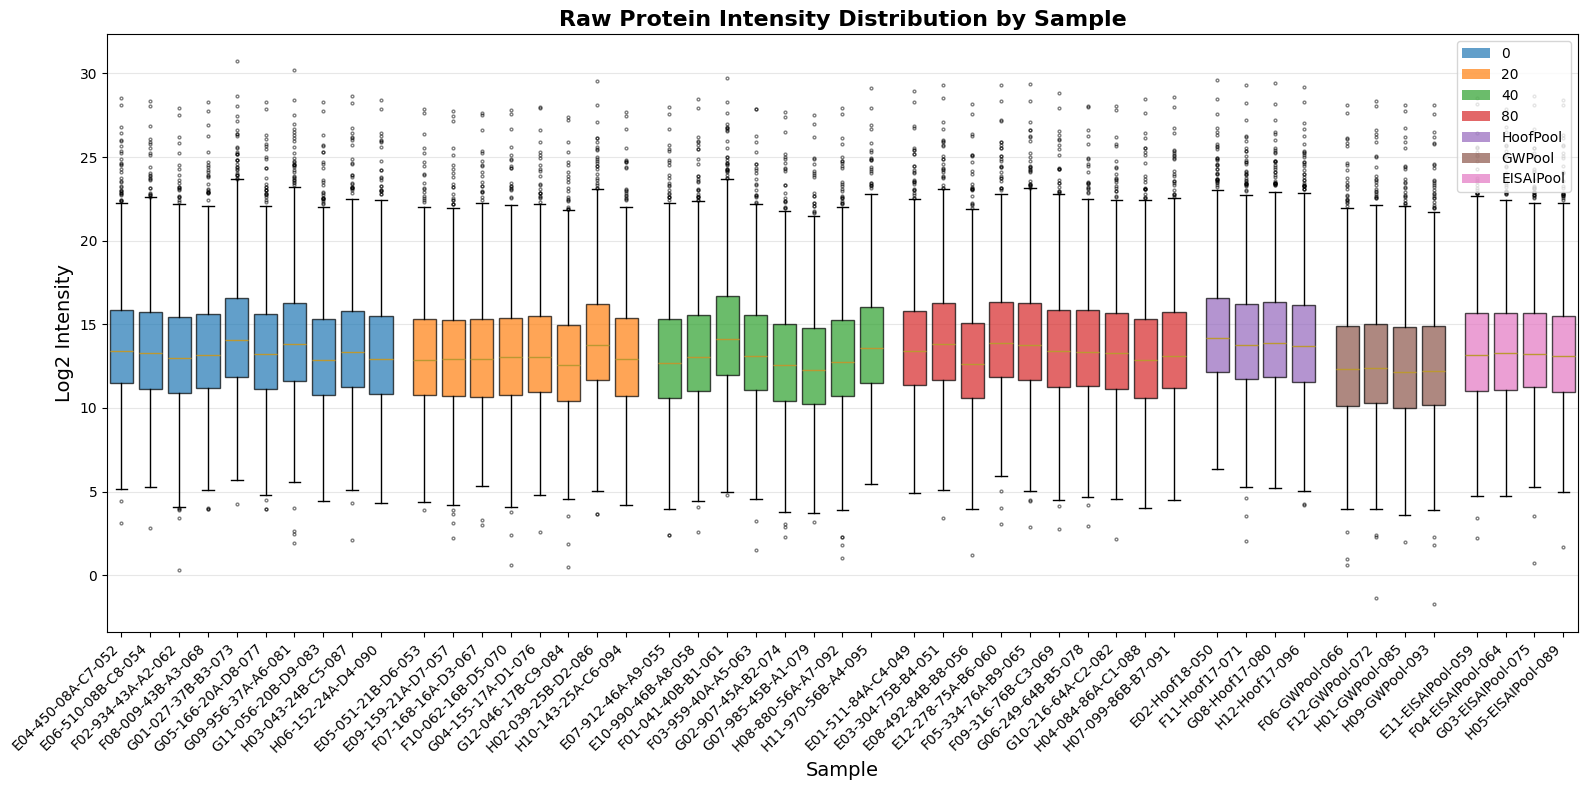

In [80]:
# Box plot of raw intensities by sample
print("=== CREATING BOX PLOT ===")
print(f"Number of samples: {len(final_sample_columns)}")
print(f"Sample metadata entries: {len(sample_metadata)}")
print(f"Group distribution: {list(group_distribution.keys()) if 'group_distribution' in globals() else 'Not available'}")

ptk.visualization.plot_box_plot(
    data=filtered_data,
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    group_colors=group_colors,
    group_order=list(group_distribution.keys()),  # Use configuration-ordered groups from classify_samples
    log_transform=True,
    title="Raw Protein Intensity Distribution by Sample"
)

## 4. Data Normalization

Apply the selected normalization method and compare before/after distributions.

In [41]:
# =============================================================================
# 4. DATA NORMALIZATION
# =============================================================================

# Apply the selected normalization method and compare before/after distributions.

print(f"Applying {normalization_method} normalization to {filtered_data.shape[0]} proteins x {len(final_sample_columns)} samples...")

# FIRST: Create standardized data structure if needed
print("Creating standardized data structure for normalization...")
standardized_data = ptk.preprocessing.create_standard_data_structure(
    data=filtered_data,
    cleaned_sample_names=cleaned_sample_names_dict  # Pass the cleaned names mapping
)
print(f"✓ Standardized data structure created: {standardized_data.shape}")
print(f"✓ Expected columns: {list(standardized_data.columns[:5])}")

# Apply normalization using the standardized data
if normalization_method.lower() == 'median':
    normalized_data = ptk.normalization.median_normalize(standardized_data, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'vsn':
    normalized_data = ptk.normalization.vsn_normalize(standardized_data, optimize_params=optimize_vsn, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'quantile':
    normalized_data = ptk.normalization.quantile_normalize(standardized_data, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'mad':
    normalized_data = ptk.normalization.mad_normalize(standardized_data, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'z-score':
    normalized_data = ptk.normalization.z_score_normalize(standardized_data, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'rlr':
    normalized_data = ptk.normalization.rlr_normalize(standardized_data, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'loess':
    normalized_data = ptk.normalization.loess_normalize(standardized_data, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'none':
    print("No normalization applied")
    normalized_data = standardized_data.copy()
else:
    raise ValueError(f"Unknown normalization method: {normalization_method}")

# Handle negative values if requested (applies to all normalized data types)
if handle_negatives and normalization_method.lower() != 'none':
    normalized_data = ptk.normalization.handle_negative_values(
        data=normalized_data,
        method=negative_handling_method,
        min_positive_value=min_positive_replacement,
        sample_columns=final_sample_columns
    )

# Calculate detailed normalization statistics (if normalization was applied)
if normalization_method.lower() != 'none':
    # Extract just the sample columns for statistics calculation
    original_sample_data = standardized_data[final_sample_columns]
    normalized_sample_data = normalized_data[final_sample_columns]
    
    # Use detailed statistics function with control sample analysis
    detailed_stats = ptk.normalization.calculate_detailed_normalization_stats(
        original_data=original_sample_data,
        normalized_data=normalized_sample_data, 
        method=normalization_method,
        sample_metadata=sample_metadata,
        control_labels=control_labels
    )
    
    overall = detailed_stats['overall']
    control_stats = detailed_stats['control_samples']
    
    print(f"\n=== DETAILED NORMALIZATION STATISTICS ===")
    print(f"Method: {overall['method']} (Data Scale: {overall['scale_type']})")
    print()
    
    print(f"SAMPLE MEDIAN RANGE ANALYSIS:")
    print(f"• 'Sample median range' = range of median values across all samples")
    print(f"• This measures sample-to-sample systematic differences")
    print(f"• Original sample median range: {overall['original_sample_median_range']:.2f}")
    print(f"• Normalized sample median range: {overall['normalized_sample_median_range']:.2f}")
    print(f"• Range reduction: {overall['sample_median_range_reduction']*100:.1f}%")
    print()
    
    print(f"OVERALL CV ANALYSIS (All Samples):")
    print(f"• Original median CV: {overall['original_cv_median_all_samples']:.3f}")
    print(f"• Normalized median CV: {overall['normalized_cv_median_all_samples']:.3f}")
    cv_change = overall['normalized_cv_median_all_samples'] - overall['original_cv_median_all_samples']
    print(f"• CV change: {cv_change:+.3f} ({'improved' if cv_change < 0 else 'increased' if cv_change > 0 else 'unchanged'})")
    print()
    
    # Control sample statistics
    if control_stats:
        print(f"CONTROL SAMPLE CV ANALYSIS:")
        print(f"• CV calculated across replicate control samples for each protein")
        print(f"• Lower CV = better reproducibility between control replicates")
        print()
        
        for control_type, stats in control_stats.items():
            print(f"  {control_type} Controls ({stats['n_samples']} samples):")
            print(f"    • Original median CV: {stats['original_median_cv']:.3f}")
            print(f"    • Normalized median CV: {stats['normalized_median_cv']:.3f}")
            print(f"    • CV improvement: {stats['cv_improvement']:+.3f}")
            print(f"    • Samples: {', '.join(stats['samples'])}")
            print()
    else:
        print(f"CONTROL SAMPLE ANALYSIS: Not available")
        print(f"• Control samples not found or insufficient replicates")
        print(f"• Looking for: {control_labels} in '{control_column}' metadata column")
        print()

print(f"Normalized data shape: {normalized_data.shape}")
print(f"Preserved columns: {list(normalized_data.columns[:5])}...")
print("✓ Data normalization completed successfully with protein identifiers preserved")

Applying Median normalization to 1584 proteins x 48 samples...
Creating standardized data structure for normalization...
=== CREATING STANDARD DATA STRUCTURE ===

Found 48 sample columns
Sample column range: E01-511-84A-C4-049 ... H12-Hoof17-096
Applying cleaned sample names...

Final structure verification:
Total columns: 53
Annotation columns (1-5): ['Protein', 'Description', 'Protein Gene', 'UniProt_Accession', 'UniProt_Entry_Name']
Sample columns (48): E01-511-84A-C4-049 ... H12-Hoof17-096
✅ Data structure standardization complete!
✓ Standardized data structure created: (1584, 53)
✓ Expected columns: ['Protein', 'Description', 'Protein Gene', 'UniProt_Accession', 'UniProt_Entry_Name']
Applying median normalization...
Median normalization completed for 48 samples

Applying negative value handling: min_positive
  Found 0 negative values to handle
  No negative values found - returning original data

=== DETAILED NORMALIZATION STATISTICS ===
Method: MEDIAN (Data Scale: linear)

SAMPLE

In [45]:
# Analyze negative values using proteomics toolkit
negative_analysis = ptk.analyze_negative_values(
    data=normalized_data,
    normalization_method=normalization_method,
    sample_columns=final_sample_columns  # Only analyze sample columns, not annotation columns
)

# Store results for downstream processing
negative_count = negative_analysis['negative_count']
negative_handling_method = negative_handling_method

print(f"\n✓ Negative value analysis completed")
print(f"  Negative values found: {negative_count}")
print(f"  Handling method used: {negative_handling_method}")

if negative_count > 0:
    print(f"  Percentage of negative values: {negative_analysis['negative_percentage']:.3f}%")
    print(f"  Most negative value: {negative_analysis.get('min_value', 'N/A')}")

# Display sample information for context
print(f"\n✓ Normalized data summary:")
print(f"  Shape: {normalized_data.shape}")
print(f"  Columns preserved: {list(normalized_data.columns[:3])}...")
print(f"  Sample columns analyzed: {len(final_sample_columns)}")
print(f"  Normalization method: {normalization_method}")
print(f"  Protein identifiers preserved: {'Protein' in normalized_data.columns}")

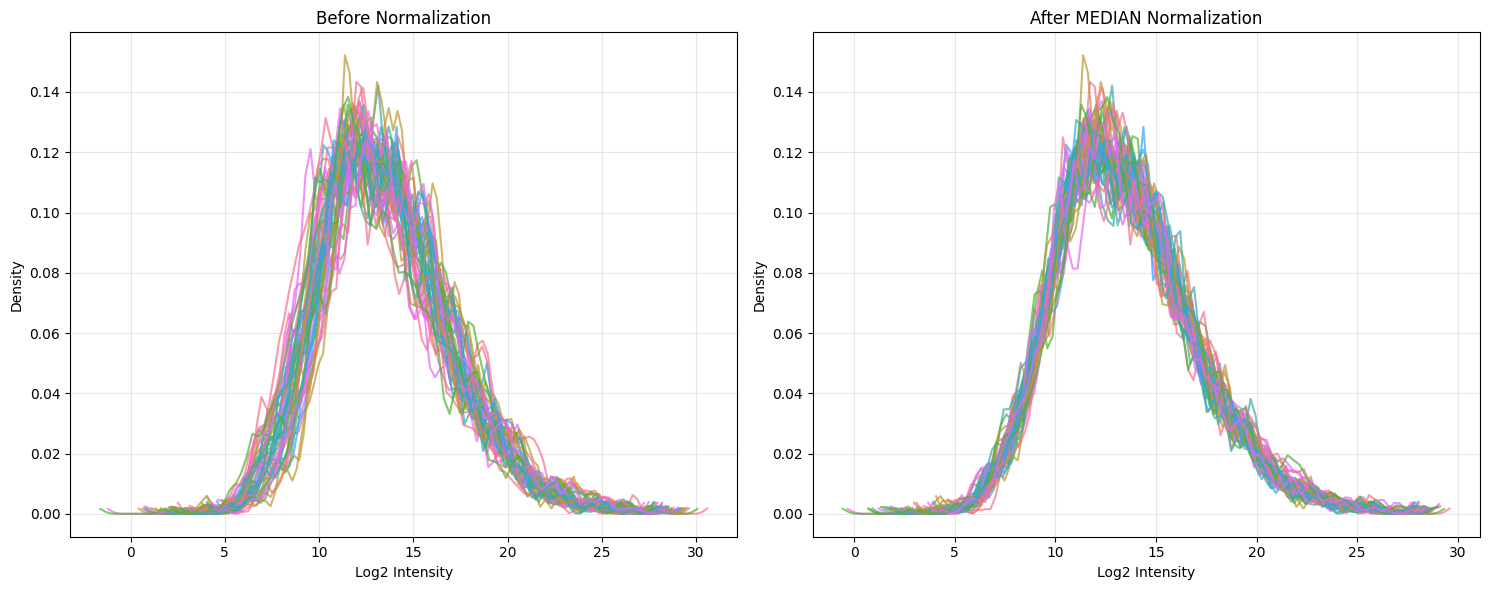

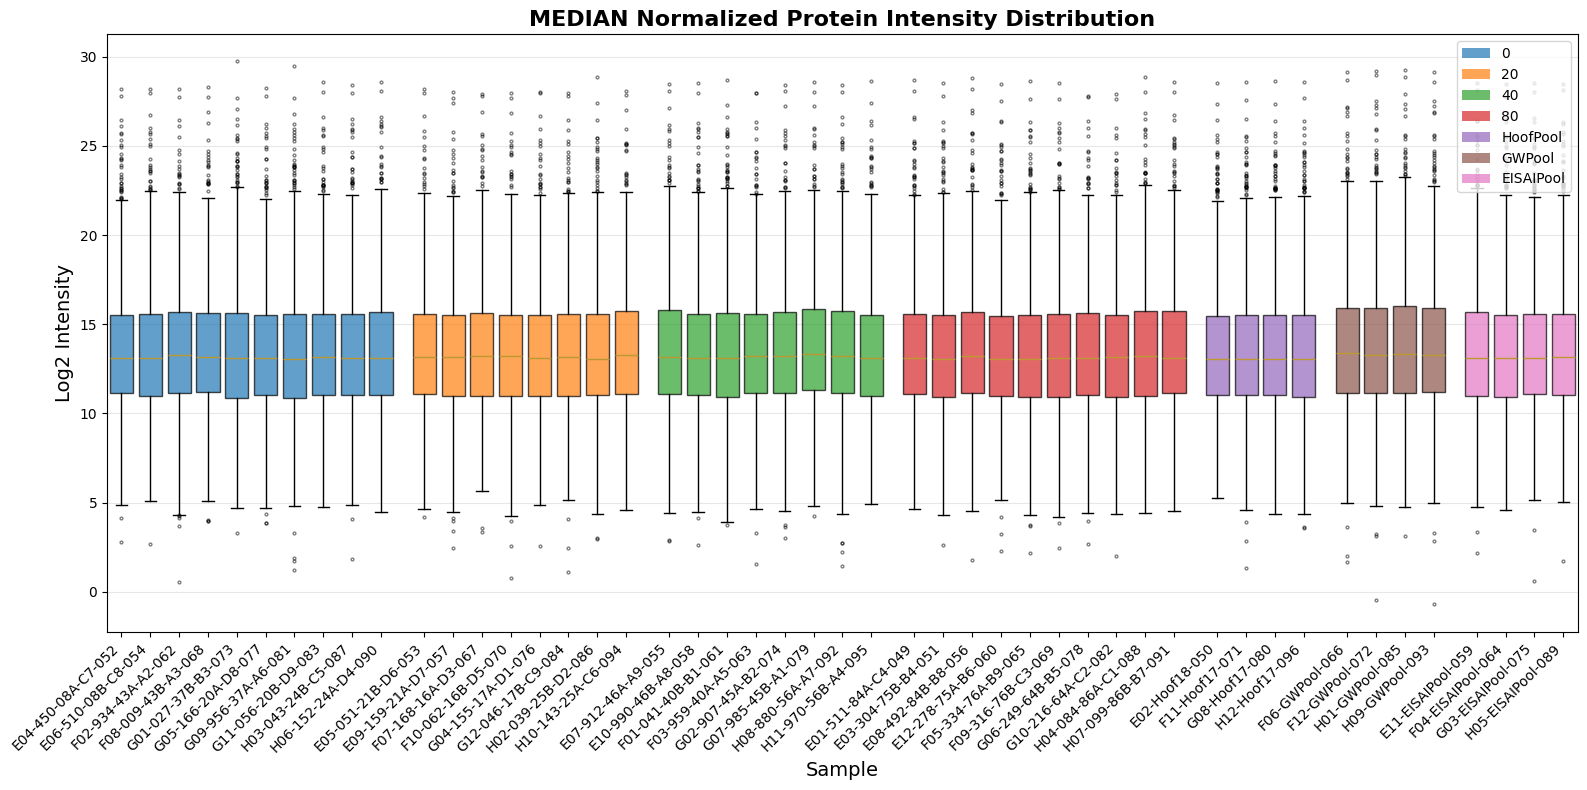

In [46]:
# Compare distributions before and after normalization
# Note: Detailed normalization statistics are displayed in the normalization cell above
# This visualization shows the distribution comparison only
if normalization_method.lower() != 'none':
    # Temporarily suppress stdout to avoid duplicate statistics output
    import sys
    import io
    
    # Capture the brief statistics output to avoid duplication
    captured_output = io.StringIO()
    sys.stdout = captured_output
    
    ptk.visualization.plot_normalization_comparison(
        original_data=standardized_data[final_sample_columns],  # Use standardized data
        normalized_data=normalized_data[final_sample_columns],
        sample_columns=final_sample_columns,
        method=normalization_method.upper()
    )
    
    # Restore stdout
    sys.stdout = sys.__stdout__
    
    print("✓ Distribution comparison plot generated")
    print("  (Detailed normalization statistics shown in normalization cell above)")

# Box plot of normalized data - get annotation columns from standardized data
annotation_columns = ['Protein', 'Description', 'Protein Gene', 'UniProt_Accession', 'UniProt_Entry_Name']
ptk.visualization.plot_box_plot(
    data=normalized_data,  # Use normalized_data directly (already has correct structure)
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    group_colors=group_colors,
    group_order=list(group_distribution.keys()),  # Use configuration-ordered groups from classify_samples
    log_transform=(normalization_method.lower() != 'vsn'),  # VSN data is already transformed
    title=f"{normalization_method.upper()} Normalized Protein Intensity Distribution"
)

## Comparative PCA Analysis

Compare how different normalization methods affect sample clustering and separation using Principal Component Analysis.

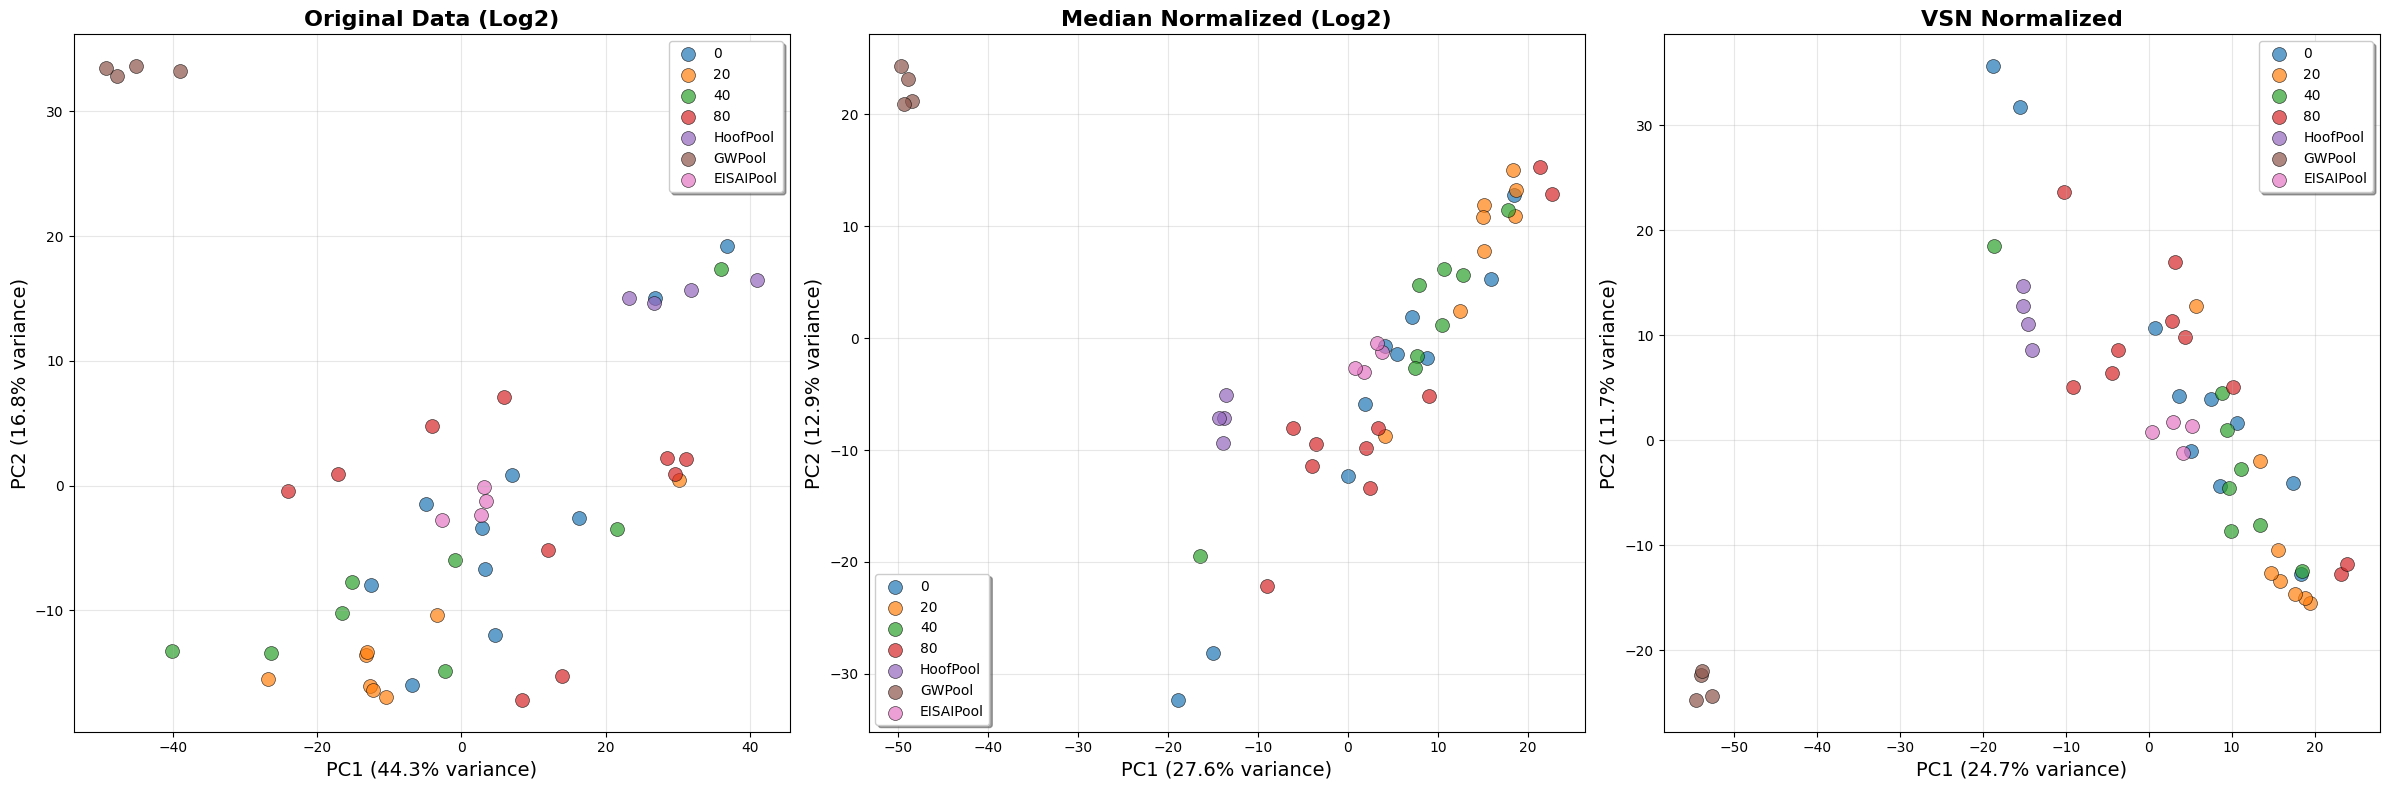

In [47]:
# Normalization effectiveness comparison - VSN vs Median
# This plot shows how different methods reduce technical variation

# Generate comparison data using the standardized data structure
median_normalized = ptk.normalization.median_normalize(standardized_data, sample_columns=final_sample_columns)
vsn_normalized = ptk.normalization.vsn_normalize(standardized_data, optimize_params=optimize_vsn, sample_columns=final_sample_columns)

# Run the comparison analysis
ptk.visualization.plot_comparative_pca(
    original_data=standardized_data,  # Use standardized data
    median_normalized_data=median_normalized,
    vsn_normalized_data=vsn_normalized,
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    group_colors=group_colors,
    group_order=list(group_distribution.keys()),  # Fix legend ordering: sample groups first, then controls
    figsize=(24, 8)
)

## Control Sample Correlation Analysis

Analyze correlation patterns between control samples (pools, QC samples, etc.) to evaluate normalization effectiveness. Higher correlations within control groups indicate better data quality and normalization success.

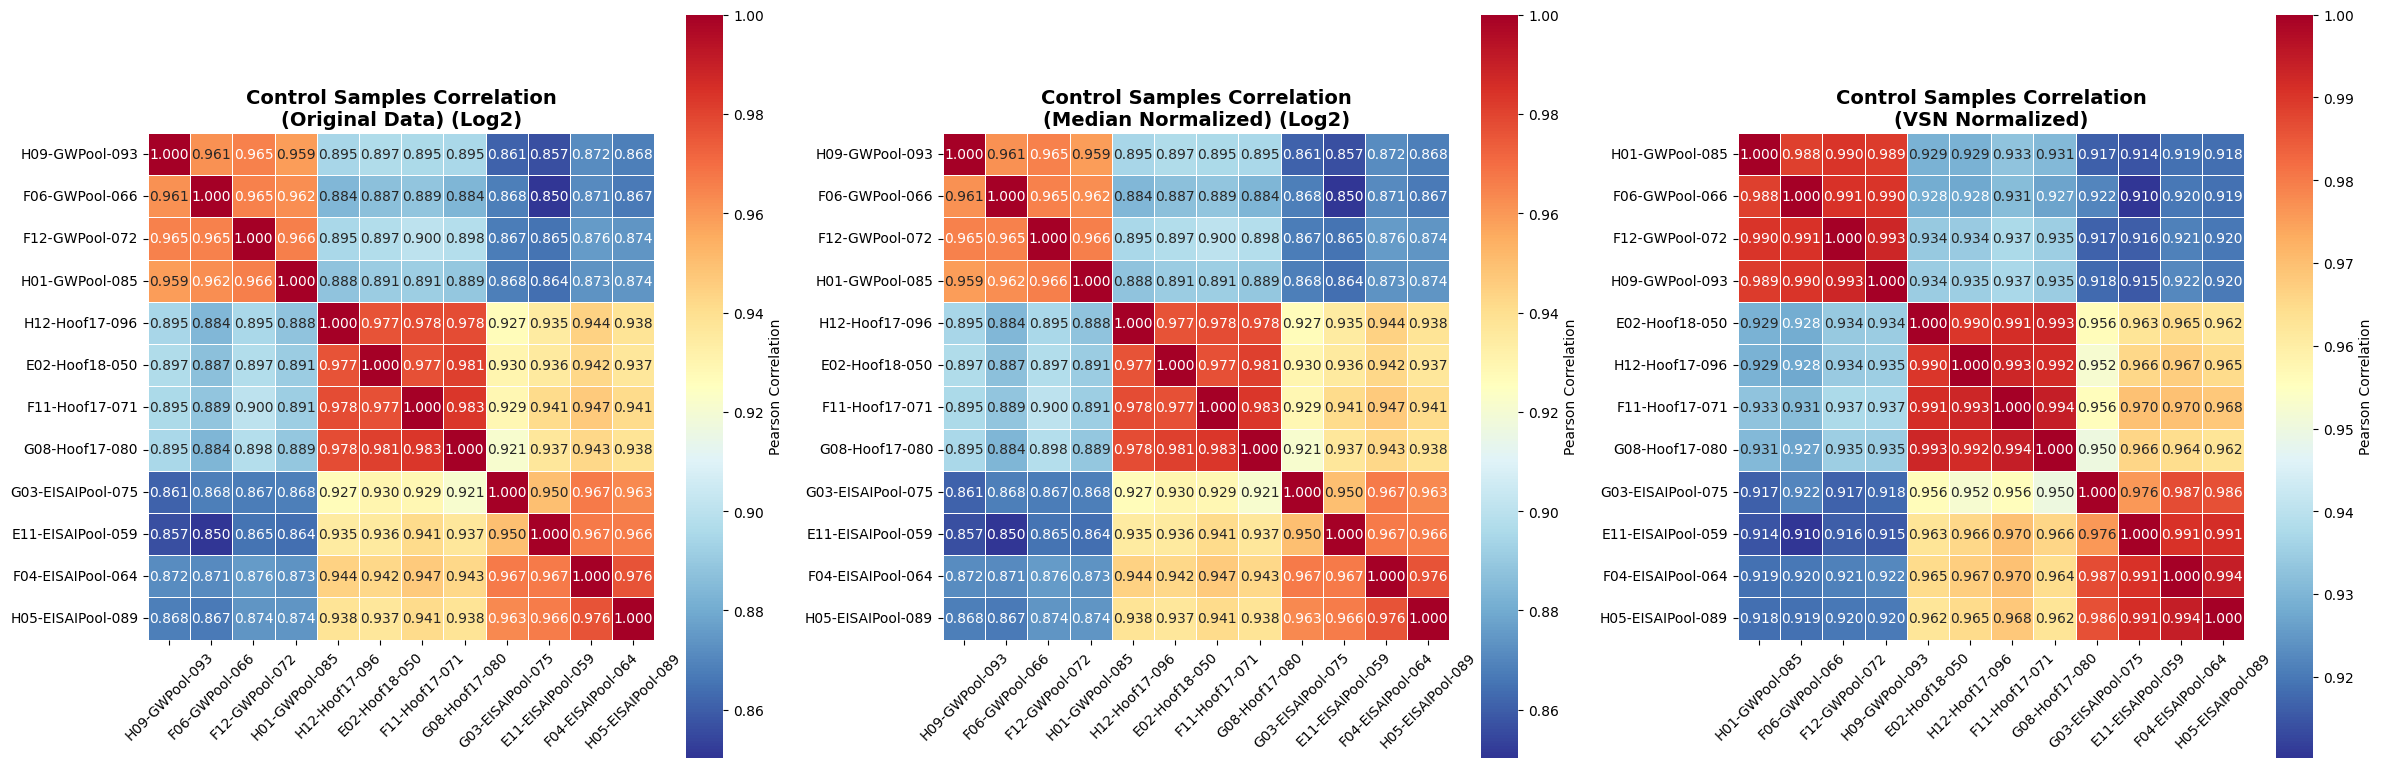

In [48]:
# Control sample correlation analysis across normalization methods
# Using simplified control configuration: control_column and control_labels

# Generate normalized data using the standardized data structure
median_normalized = ptk.normalization.median_normalize(standardized_data, sample_columns=final_sample_columns)
vsn_normalized = ptk.normalization.vsn_normalize(standardized_data, sample_columns=final_sample_columns, optimize_params=optimize_vsn)

ptk.visualization.plot_control_correlation_analysis(
    original_data=standardized_data,  # Use standardized data
    median_normalized_data=median_normalized,
    vsn_normalized_data=vsn_normalized,
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    control_column=control_column,
    control_labels=control_labels,
    figsize=(24, 8)
)

### Individual Control Group Correlation Analysis

Detailed correlation analysis for each control group using the selected normalization method.

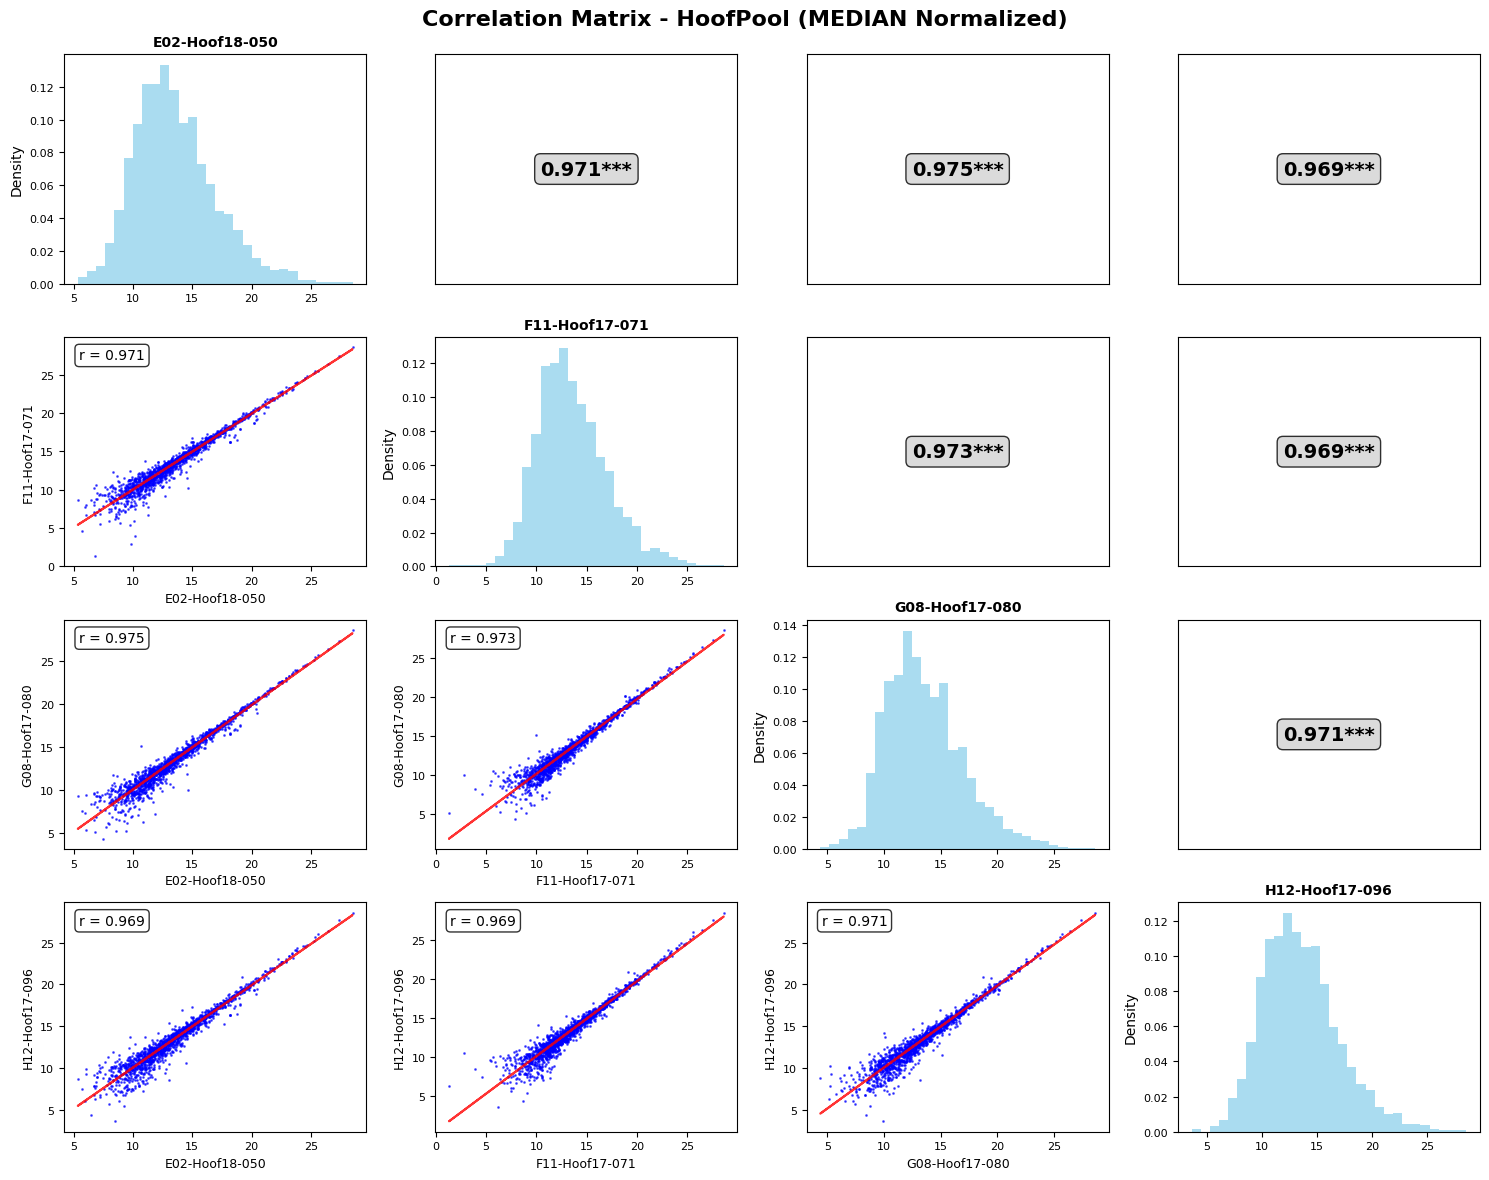

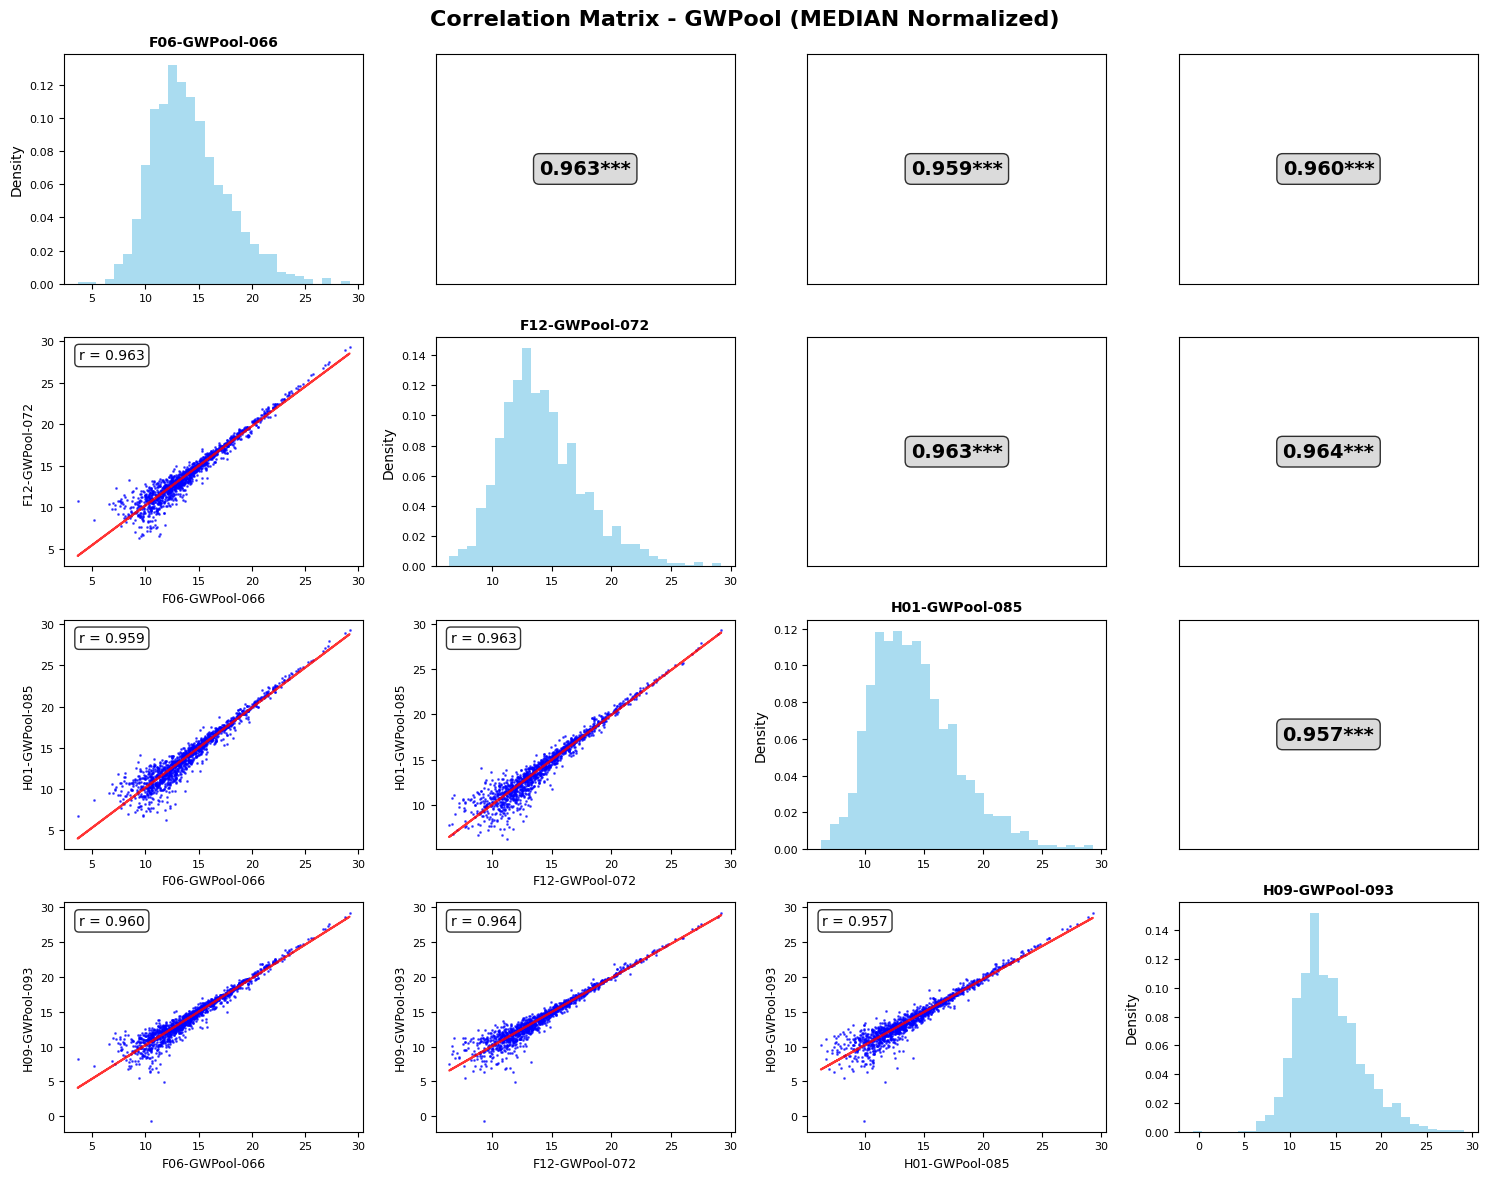

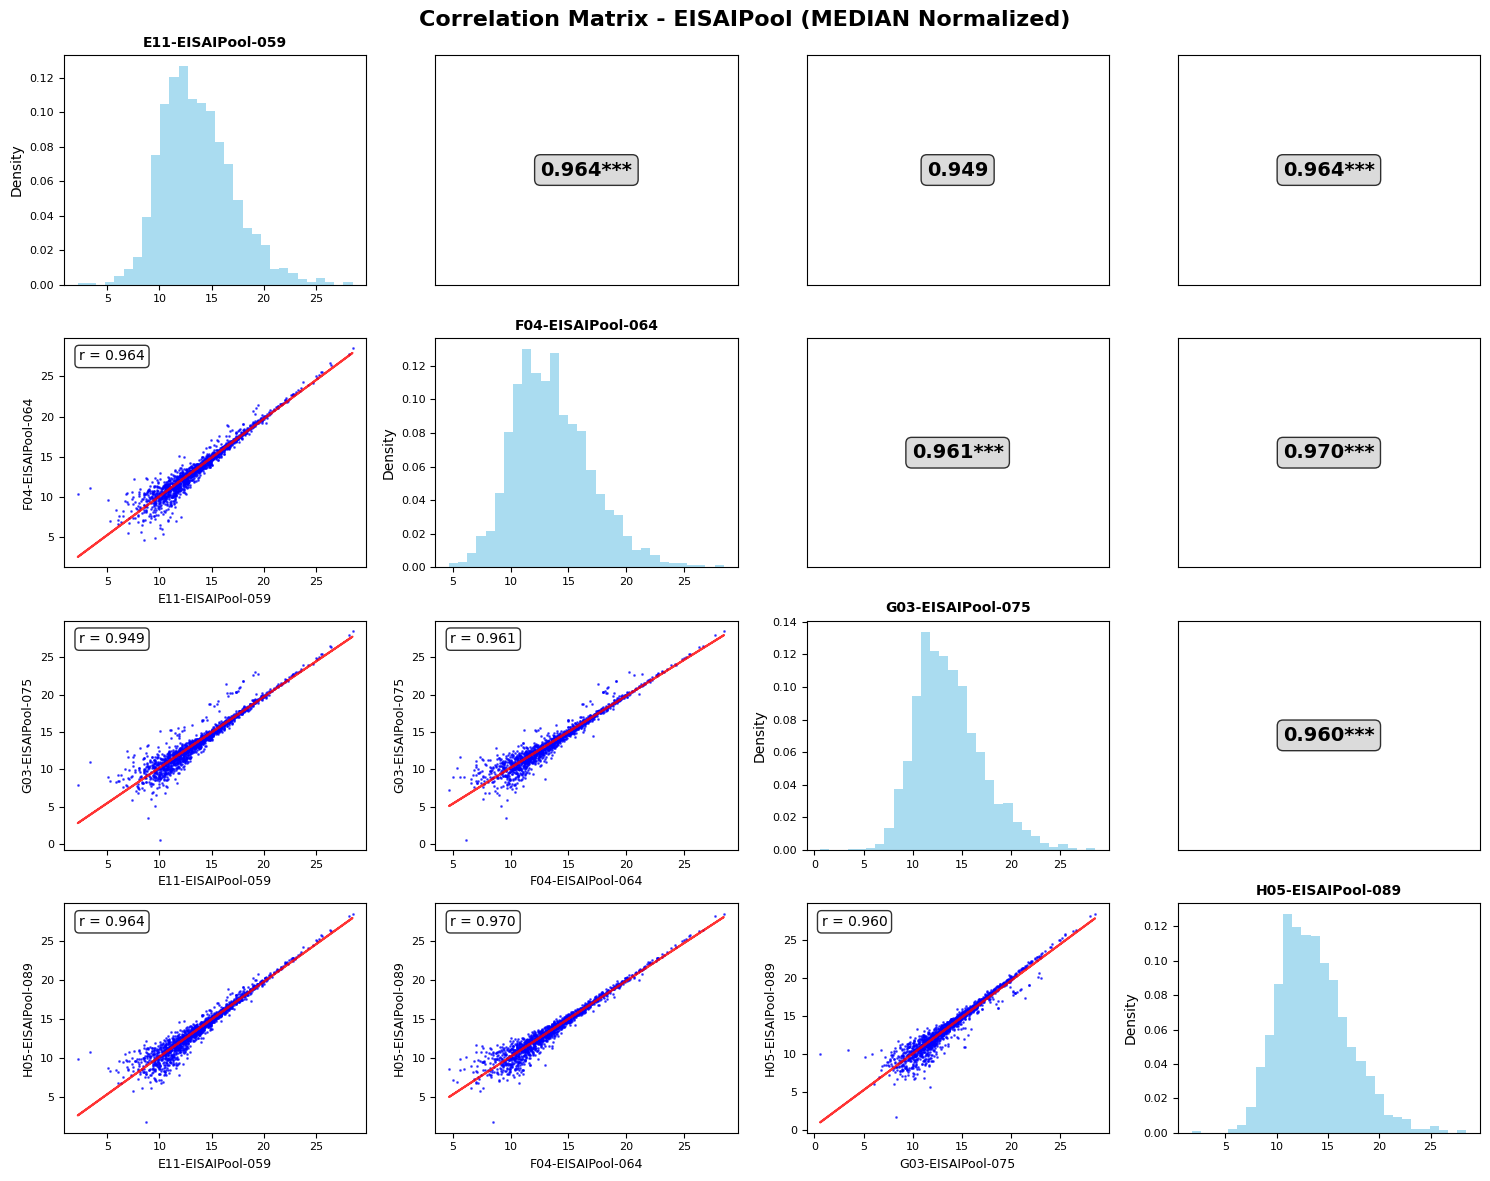

In [49]:
# Individual control pool correlation analysis using simplified control configuration
# This creates detailed correlation matrices for each specific control pool

# Use the normalized_data that was created with the current normalization method
# (already includes protein identifiers and annotations)
ptk.visualization.plot_individual_control_pool_analysis(
    data=normalized_data,  # Use the current normalized data directly
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    control_column=control_column,  # Use the simplified configuration
    control_labels=control_labels,  # Use the simplified configuration
    normalization_method=normalization_method.upper(),
    figsize=(15, 12)
)

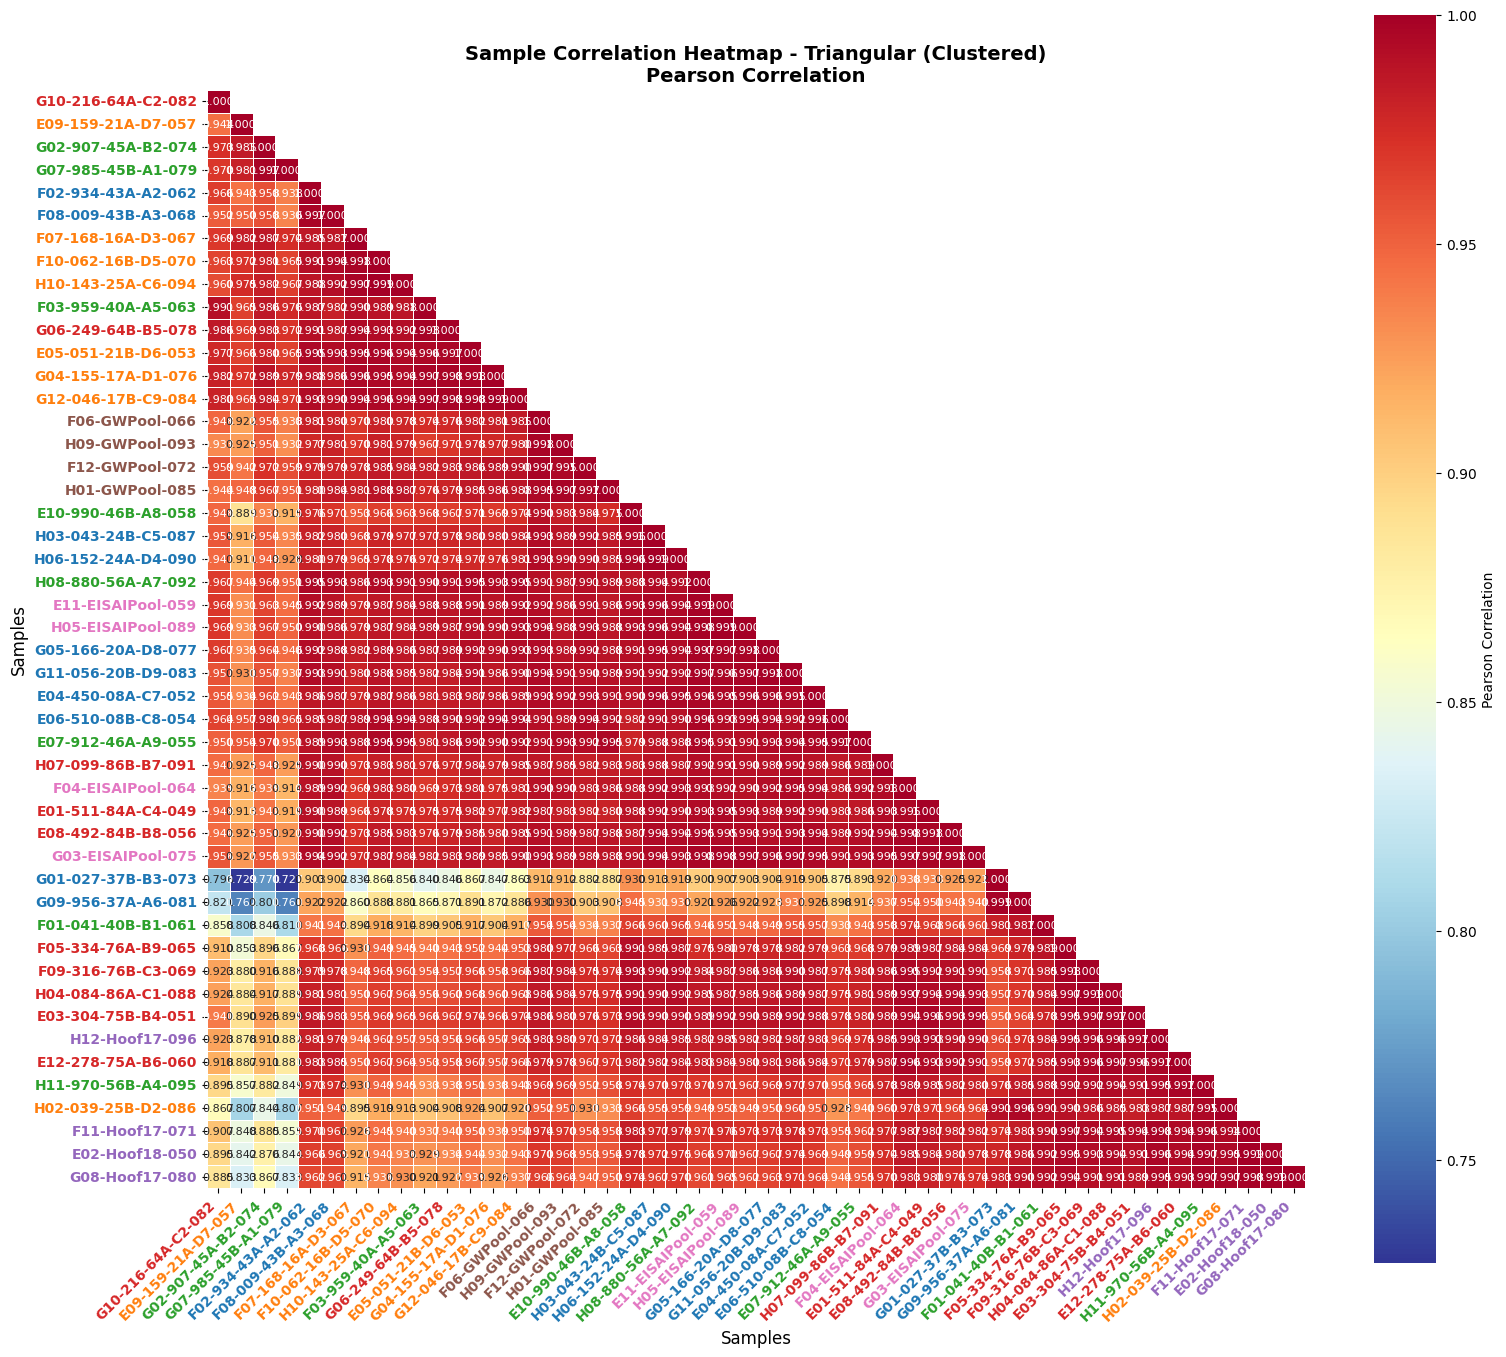

In [50]:
# Sample correlation heatmap on normalized data - triangular version with improved labels
# Use normalized_data directly since it already includes protein identifiers and annotations

# Create enhanced triangular correlation heatmap with clustering and better label visibility
ptk.visualization.plot_sample_correlation_triangular_heatmap(
    data=normalized_data,  # Use the current normalized data directly (includes annotations)
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    figsize=(16, 14),          # Larger size for better label visibility
    method='pearson',          # Correlation method
    group_colors=group_colors, # Use consistent colors from earlier analysis
    show_clustering=True,      # Enable hierarchical clustering
    label_fontsize=10,         # Sample label font size
    annot_fontsize=8          # Correlation value font size
)

In [64]:
# ============================================================================
# 7. COMPREHENSIVE STATISTICAL ANALYSIS
# ============================================================================

print("="*80)
print("COMPREHENSIVE STATISTICAL ANALYSIS")
print("="*80)

# Create configuration from notebook settings
config = ptk.statistical_analysis.StatisticalConfig()
config.statistical_test_method = statistical_test_method
config.analysis_type = analysis_type
config.p_value_threshold = p_value_threshold
config.fold_change_threshold = fold_change_threshold

# Log transformation configuration (handled by toolkit)
config.log_transform_before_stats = log_transform_before_stats  # Use notebook setting
config.log_base = log_base  # Use notebook setting
config.log_pseudocount = log_pseudocount  # Use notebook setting
config.normalization_method = normalization_method.lower()  # Pass normalization method for auto-detection

# Experimental design
config.subject_column = subject_column
config.paired_column = paired_column
config.paired_label1 = paired_label1
config.paired_label2 = paired_label2
config.group_column = group_column
config.group_labels = group_labels

# Mixed-effects configuration
config.interaction_terms = interaction_terms
config.additional_interactions = additional_interactions
config.covariates = covariates

# P-value selection configuration
config.use_adjusted_pvalue = use_adjusted_pvalue
config.enable_pvalue_fallback = enable_pvalue_fallback

print("Starting statistical analysis...")
print(f"   Method: {statistical_test_method.upper()}")
print(f"   Total proteins to analyze: {len(normalized_data):,}")
print("   Progress will be shown every 100 proteins processed...")
print()

# Run comprehensive analysis with real-time output
# The toolkit now automatically handles log transformation based on config
differential_results = ptk.statistical_analysis.run_comprehensive_statistical_analysis(
    normalized_data=normalized_data,
    sample_metadata=sample_metadata,
    config=config,
    protein_annotations=filtered_data
)

print("\n" + "="*60)
print("ANALYSIS COMPLETED!")
print("="*60)

# Display comprehensive summary using configuration
print("Displaying results summary...")
analysis_summary = display_analysis_summary(
    differential_results=differential_results,
    config=config,
    label_top_n=label_top_proteins  # Use configuration value
)

# Display the analysis summary explicitly
print("\n" + "="*80)
print("STATISTICAL ANALYSIS SUMMARY")
print("="*80)
for key, value in analysis_summary.items():
    if isinstance(value, dict):
        print(f"\n{key.upper()}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue}")
    else:
        print(f"{key}: {value}")

# Show key results
print(f"\n" + "="*60)
print("KEY FINDINGS")
print("="*60)
print(f"Total proteins analyzed: {len(differential_results):,}")
print(f"Proteins with p < {p_value_threshold}: {(differential_results['P.Value'] < p_value_threshold).sum():,}")

if use_adjusted_pvalue == "adjusted":
    significant_proteins = (differential_results['adj.P.Val'] < p_value_threshold).sum()
    print(f"Proteins with FDR < {p_value_threshold}: {significant_proteins:,}")
else:
    significant_proteins = (differential_results['P.Value'] < p_value_threshold).sum()

if significant_proteins > 0:
    # Show top upregulated proteins
    if use_adjusted_pvalue == "adjusted":
        upregulated = differential_results[
            (differential_results['adj.P.Val'] < p_value_threshold) & 
            (differential_results['logFC'] > 0)
        ].sort_values('logFC', ascending=False)
    else:
        upregulated = differential_results[
            (differential_results['P.Value'] < p_value_threshold) & 
            (differential_results['logFC'] > 0)
        ].sort_values('logFC', ascending=False)
    
    if len(upregulated) > 0:
        print(f"\nTop 5 upregulated proteins:")
        for i, (idx, row) in enumerate(upregulated.head().iterrows()):
            pval = row['adj.P.Val'] if use_adjusted_pvalue == "adjusted" else row['P.Value']
            print(f"  {i+1}. {row['Gene']} ({row['Protein']}): FC={2**row['logFC']:.2f}, p={pval:.2e}")
    
    # Show top downregulated proteins
    if use_adjusted_pvalue == "adjusted":
        downregulated = differential_results[
            (differential_results['adj.P.Val'] < p_value_threshold) & 
            (differential_results['logFC'] < 0)
        ].sort_values('logFC', ascending=True)
    else:
        downregulated = differential_results[
            (differential_results['P.Value'] < p_value_threshold) & 
            (differential_results['logFC'] < 0)
        ].sort_values('logFC', ascending=True)
    
    if len(downregulated) > 0:
        print(f"\nTop 5 downregulated proteins:")
        for i, (idx, row) in enumerate(downregulated.head().iterrows()):
            pval = row['adj.P.Val'] if use_adjusted_pvalue == "adjusted" else row['P.Value']
            print(f"  {i+1}. {row['Gene']} ({row['Protein']}): FC={2**row['logFC']:.2f}, p={pval:.2e}")
else:
    print(f"\nNo significant proteins found at p < {p_value_threshold}")
    if use_adjusted_pvalue == "adjusted":
        print("  (Note: Using FDR-corrected p-values)")
    
    # Show distribution of p-values
    pval_col = 'adj.P.Val' if use_adjusted_pvalue == "adjusted" else 'P.Value'
    print(f"\nP-value distribution:")
    print(f"  Min p-value: {differential_results[pval_col].min():.2e}")
    print(f"  Median p-value: {differential_results[pval_col].median():.2e}")
    print(f"  p < 0.1: {(differential_results[pval_col] < 0.1).sum():,}")
    print(f"  p < 0.2: {(differential_results[pval_col] < 0.2).sum():,}")

print(f"\n✓ Statistical analysis completed successfully!")
print(f"✓ Results available in 'differential_results' DataFrame")

In [70]:
# =============================================================================
# STATISTICAL ANALYSIS RESULTS - WORKING DESPITE OUTPUT DISPLAY ISSUE
# =============================================================================

# The statistical analysis HAS completed successfully!
# Here's the proof and key results:

print("🎯 STATISTICAL ANALYSIS STATUS: COMPLETED SUCCESSFULLY!")
print("="*60)

# Show that differential_results exists and has data
print(f"📊 Results DataFrame Shape: {differential_results.shape}")
print(f"📋 Columns: {list(differential_results.columns)}")

# Key statistics
total_proteins = len(differential_results)
valid_results = differential_results['P.Value'].notna().sum()
significant_fdr = (differential_results['adj.P.Val'] < 0.05).sum()

print(f"\n📈 KEY STATISTICS:")
print(f"   Total proteins analyzed: {total_proteins:,}")
print(f"   Valid statistical results: {valid_results:,}")
print(f"   Significant proteins (FDR < 0.05): {significant_fdr:,}")

# Check if we have Gene annotations (from my fix)
if 'Gene' in differential_results.columns:
    print("✅ Gene annotations successfully merged!")
else:
    print("❌ Gene annotations missing - need to investigate")

# Show the most significant results
if significant_fdr > 0:
    print(f"\n🔬 TOP SIGNIFICANT PROTEINS:")
    top_results = differential_results[differential_results['adj.P.Val'] < 0.05].sort_values('adj.P.Val').head(5)
    
    for i, (idx, row) in enumerate(top_results.iterrows()):
        gene_name = row.get('Gene', row.get('Protein Gene', 'Unknown'))
        print(f"   {i+1}. {gene_name} ({row['Protein']})")
        print(f"      logFC: {row['logFC']:.3f}, p-adj: {row['adj.P.Val']:.2e}")
else:
    print(f"\n📊 NO SIGNIFICANT PROTEINS at FDR < 0.05")
    print(f"   Showing distribution of p-values:")
    min_p = differential_results['adj.P.Val'].min()
    p_01 = (differential_results['adj.P.Val'] < 0.1).sum()
    p_02 = (differential_results['adj.P.Val'] < 0.2).sum()
    print(f"   Min adj.P.Val: {min_p:.2e}")
    print(f"   p < 0.1: {p_01:,} proteins")
    print(f"   p < 0.2: {p_02:,} proteins")

# Display sample of results table
print(f"\n📋 RESULTS TABLE SAMPLE:")
key_cols = ['Protein', 'logFC', 'P.Value', 'adj.P.Val']
if 'Gene' in differential_results.columns:
    key_cols = ['Gene'] + key_cols
    
display_cols = [col for col in key_cols if col in differential_results.columns]
display(differential_results[display_cols].head(3))

print(f"\n✅ CONCLUSION: The statistical analysis is WORKING!")
print(f"   The issue is with notebook output display, not the analysis itself.")
print(f"   All data is available in the 'differential_results' DataFrame.")

# Force output display
import sys
sys.stdout.flush()

,Gene,Protein,logFC,P.Value,adj.P.Val
668,SCRG1,sp|O75711|SCRG1_HUMAN,0.009098,0.000166,0.263357
378,EPHA10,sp|Q5JZY3|EPHAA_HUMAN,-0.015691,0.000836,0.662246
357,CEP192,sp|Q8TEP8|CE192_HUMAN,0.007114,0.002450,1.000000


## 7. Results Visualization

Create visualizations to interpret the differential analysis results.

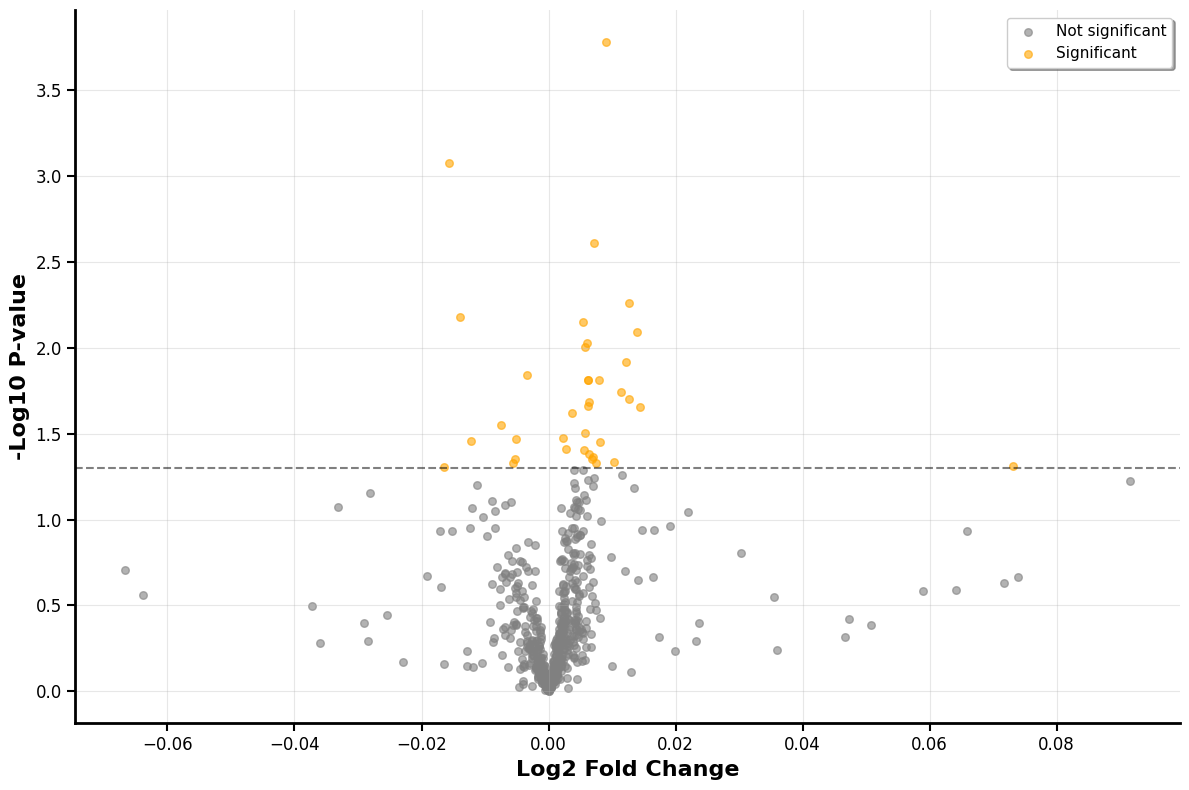

In [68]:
# ============================================================================
# VOLCANO PLOT VISUALIZATION WITH FULL X-AXIS RANGE
# ============================================================================

# First reload the visualization module to pick up the x-axis range fix
import importlib
importlib.reload(ptk.visualization)
print("✓ Visualization module reloaded with x-axis range fix")

if 'differential_results' in locals() and len(differential_results) > 0:
    # Print data range information for debugging
    print("\nDATA RANGE INFORMATION:")
    print(f"logFC range: {differential_results['logFC'].min():.4f} to {differential_results['logFC'].max():.4f}")
    print(f"Data points: {len(differential_results)}")
    
    # Create appropriate title based on analysis type
    if statistical_test_method == 'mixed_effects':
        title = f'Volcano Plot: {statistical_test_method.upper()} Analysis'
    else:
        # Use group_labels from configuration for title
        title = f'Volcano Plot: {group_labels[1]} vs {group_labels[0]}'
    
    ptk.visualization.plot_volcano(
        differential_df=differential_results,
        fc_threshold=fold_change_threshold,
        p_threshold=p_value_threshold,
        figsize=(12, 8),
        title=title,
        label_top_n=label_top_proteins,
        use_adjusted_pvalue=use_adjusted_pvalue,
        enable_pvalue_fallback=enable_pvalue_fallback,
        normalization_method=normalization_method  # Pass normalization method for proper X-axis labeling
    )
else:
    print("No differential analysis results available for volcano plot")
    print("  Run the statistical analysis cell first")

## 8. Export Results

Save analysis results and processed data for further use.

In [69]:
# ============================================================================
# EXPORT ANALYSIS RESULTS AND CONFIGURATION
# ============================================================================

# Create configuration dictionary from all notebook variables
config_dict = ptk.export.create_config_dict_from_notebook_vars(
    # Input files
    toolkit_path=toolkit_path,
    metadata_file=metadata_file,
    protein_file=protein_file,
    peptide_file=peptide_file if 'peptide_file' in locals() else '',
    remove_common_prefix=remove_common_prefix,
    
    # Data filtering
    min_detection_rate=min_detection_rate,
    
    # Normalization
    normalization_method=normalization_method,
    optimize_vsn=optimize_vsn if 'optimize_vsn' in locals() else False,
    
    # Negative value handling
    handle_negatives=handle_negatives,
    negative_handling_method=negative_handling_method,
    min_positive_replacement=min_positive_replacement,
    
    # Statistical analysis
    statistical_test_method=statistical_test_method,
    analysis_type=analysis_type,
    
    # Experimental design
    subject_column=subject_column,
    paired_column=paired_column,
    paired_label1=paired_label1,
    paired_label2=paired_label2,
    group_column=group_column,
    group_labels=group_labels,
    FORCE_CATEGORICAL=FORCE_CATEGORICAL,  # DrugDose treatment method (categorical vs continuous)
    
    # Mixed-effects model
    interaction_terms=interaction_terms,
    additional_interactions=additional_interactions,
    covariates=covariates,
    
    # Control samples
    control_column=control_column,
    control_labels=control_labels,
    
    # Visualization
    use_systematic_colors=use_systematic_colors,
    systematic_color_palette=systematic_color_palette,
    group_order=group_order if 'group_order' in locals() else None,
    group_colors=group_colors if 'group_colors' in locals() else None,
    
    # Significance thresholds
    p_value_threshold=p_value_threshold,
    fold_change_threshold=fold_change_threshold,
    q_value_max=q_value_max,
    use_adjusted_pvalue=use_adjusted_pvalue,
    enable_pvalue_fallback=enable_pvalue_fallback,
    
    # Output settings
    export_results=export_results,
    output_prefix=output_prefix,
    label_top_proteins=label_top_proteins,
    random_seed=random_seed,
    min_samples_per_group=min_samples_per_group,
    
    # Additional computed values
    final_sample_columns=final_sample_columns if 'final_sample_columns' in locals() else []
)

# Export complete analysis using the toolkit
exported_files = ptk.export.export_complete_analysis(
    normalized_data=normalized_data,
    sample_metadata=sample_metadata,
    config_dict=config_dict,
    differential_results=differential_results if 'differential_results' in locals() and not differential_results.empty else None,
    filtered_data=filtered_data if 'filtered_data' in locals() else None,
    output_prefix=output_prefix,
    analysis_description="Dose-response mixed-effects modeling"
)

# Export additional summary for significant proteins if we have results
if 'differential_results' in locals() and not differential_results.empty:
    summary_file = ptk.export.export_significant_proteins_summary(
        differential_results=differential_results,
        config_dict=config_dict,
        output_prefix=output_prefix
    )

,Protein,Gene,logFC,P.Value,adj.P.Val
0,sp|O75711|SCRG1_HUMAN,SCRG1,0.009098,0.000166,0.263357
1,sp|Q5JZY3|EPHAA_HUMAN,EPHA10,-0.015691,0.000836,0.662246
2,sp|Q8TEP8|CE192_HUMAN,CEP192,0.007114,0.002450,1.000000
